In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
os.chdir("../")
import src.utils as utils
import src.envs as envs
import src.models as mm

print(os.getcwd())
import main
from scipy.ndimage import convolve1d

from src.utils import setup_logger
logger = setup_logger(level=2)
logger(f"{logger}")

2024-11-26 19:05:42 | LoggerWrapper(name=MAIN,level=2, debugging=True, warning=True)


/Users/daniekru/Research/lab/minBandit


In [2]:
class Settings:

    verbose = False
    rounds = 2
    trials = 2
    reps = 10
    K = 10
    model = None
    load = True
    plot = False
    env = "v0"
    multiple = 1
    visual = False
    save = True
    idx = 4

---
## **single main**

**run**

In [65]:
record = {}

settings1 = Settings()
settings1.rounds = 500
settings1.trials = 2
settings1.reps = 1
settings1.verbose = True
settings1.env = "v0"

""" run """
Ks = [3]
record = {}
for i, k in tqdm(zip(range(len(Ks)), Ks)):
    settings1.K = k
    results, model = main.main(args=settings1, return_model=True)
    record[str(i)] = results

print("done")

0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:23<00:00, 11.66s/it]
1it [00:23, 23.32s/it]

done


**analysis**

In [66]:
w = np.array(results["weights"])
w.shape

(3, 1000)

In [67]:
np.array(results["rewards_list"]).flatten()

array([0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0.,
       1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

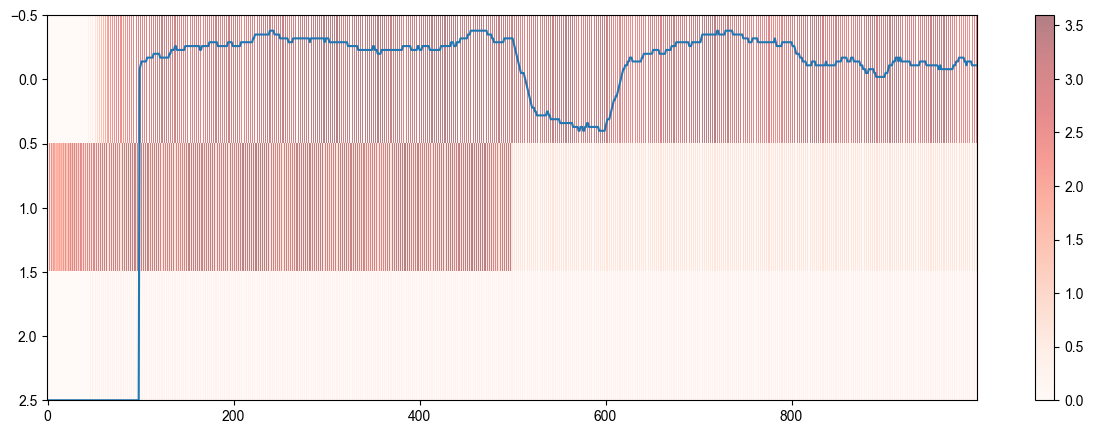

In [69]:
plt.figure(figsize=(15, 5))
plt.imshow(w, aspect="auto", interpolation="nearest", cmap="Reds", alpha=0.5)

size = 100
sc = np.convolve(np.array(results["rewards_list"]).flatten(), np.ones(size), mode='valid') / size
sc = [0] * (size - 1) + sc.tolist()
plt.plot(range(len(sc)), settings1.K-np.array(sc)*settings1.K - 0.5)
plt.colorbar()
plt.show()

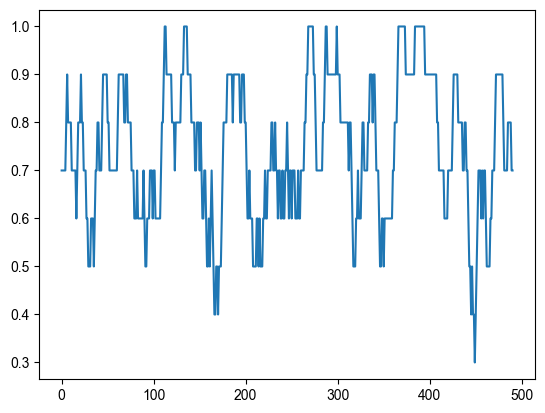

In [49]:
size = 10
sc = np.convolve(results["rewards_list"][1], np.ones(size), mode='valid') / size

plt.plot(range(len(sc)), sc);

---
## **multiple & plots**

### run

In [3]:
settings1 = Settings()
settings1.rounds = 100
settings1.trials = 2
settings1.reps = 2
settings1.verbose = True
settings1.env = "v0"

logger(f"reps:   {settings1.reps}")
logger(f"trials: {settings1.trials}")
logger(f"rounds: {settings1.rounds}")
logger(f"env:    {settings1.env}")


# parameters
K = settings1.K
nb_rounds = settings1.rounds
nb_trials = settings1.trials
nb_reps = settings1.reps
verbose = settings1.verbose
env_type = settings1.env

# define proababilities set
probabilities_set = []
for i in range(nb_trials):
    p = np.around(np.random.uniform(0.05, 0.3, K), 2)
    p[i%K] = 0.9
    # p[np.random.randint(0, K)] = 0.9
    probabilities_set += [p.tolist()]

probabilities_set = np.array(probabilities_set)

# define the environment
if env_type == "driftv0":
    env = envs.KABdriftv0(K=K,
                          probabilities_set=probabilities_set,
                          verbose=verbose,
                          tau=5)
elif env_type == "driftv1":
    env = envs.KABdriftv1(K=K,
                          verbose=verbose,
                          tau=100,
                          normalize=True,
                          fixed_p=0.9)
elif env_type == "sinv0":
    frequencies = np.linspace(0, 0.4, K)
    env = envs.KABsinv0(K=K,
                        frequencies=frequencies,
                        normalize=True,
                        verbose=verbose)
else:
    env = envs.KABv0(K=K,
                     probabilities_set=probabilities_set,
                     verbose=verbose)

if verbose:
    logger.info(f"%env: {env}")

# define models
if settings1.load:
    # params = utils.load_model(idx=args.idx,
    #                           verbose=verbose)

    idx = settings1.idx if settings1.idx >= 0 else None
    params = utils.load_model(idx=idx)
    # params["K"] = K
    params["K"] = K

else:
    params = {
        "K": K,
        "dur_pre": 2000,
        "dur_post": 2000,
        "lr": 0.1,
        "gain": 1.,
        "threshold": 0.5,
        "alpha": 0.,
        "beta": 1.,
        "mu": 0.,
        "sigma": 1.,
        "r": 1.,
        "alpha_lr": 0.1,
        "beta_lr": 0.1,
        "mu_lr": 0.1,
        "sigma_lr": 0.1,
        "r_lr": 0.1,
        "w_max": 5.,
        "value_function": "gaussian",
        "lr_function": "gaussian",
    }

model_list = [
    mm.ThompsonSampling(K=K),
    mm.EpsilonGreedy(K=K, epsilon=0.1),
    mm.UCB1(K=K),
    mm.Model(**params)
]

# run
results = envs.trial_multiple_models(
                     models=model_list,
                     environment=env,
                     nb_trials=nb_trials,
                     nb_rounds=nb_rounds,
                     nb_reps=nb_reps,
                     verbose=settings1.verbose)

results.keys(), results['reward_list'].shape

2024-11-26 19:05:42 | reps:   2
2024-11-26 19:05:42 | trials: 2
2024-11-26 19:05:42 | rounds: 100
2024-11-26 19:05:42 | env:    v0
2024-11-26 19:05:42 | %env: KABv0
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:09<00:00,  4.86s/it]


(dict_keys(['reward_list', 'chance_list', 'upper_bound_list', 'best_arm_list', 'arm_list', 'scores', 'score_list', 'mean_scores', 'entropy_list', 'names']),
 (4, 2, 2, 100))

In [7]:
results['score_list'].shape

(4, 2, 2)

In [6]:
results['entropy_list']

array([[[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.39439769,  0.39439769,  0.39439769, ...,  1.63649557,
           1.63649557,  1.63649557]],

        [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [-0.        , -0.        , -0.        , ...,  0.39439769,
           0.39439769,  0.39439769]]],


       [[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.39439769,  0.39439769,  0.39439769, ...,  0.99582132,
           0.96726044,  0.92615571]],

        [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.32508297,  0.32508297,  0.32508297, ...,  0.70834658,
           0.70834658,  0.70834658]]],


       [[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 1.69228146,  1.66040762,  1.61033317, ...

### analysis

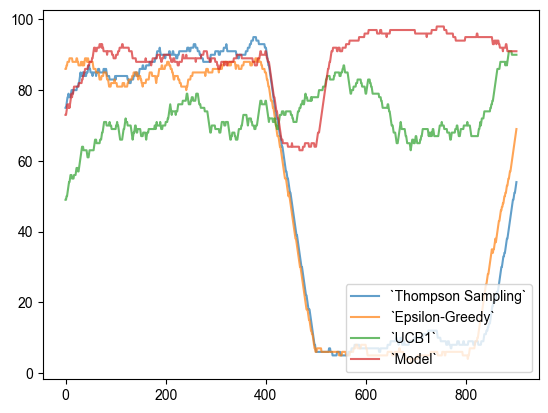

In [73]:
rw = results['reward_list'].reshape(4, -1)
kw = 100
for i in range(4):
    plt.plot(range(1000-kw+1), np.convolve(rw[i], np.ones(kw), mode='valid'),
                                      label=f"{results['names'][i]}", alpha=0.7)
plt.legend(loc="lower right")
#plt.ylim((0, 3))
plt.show()

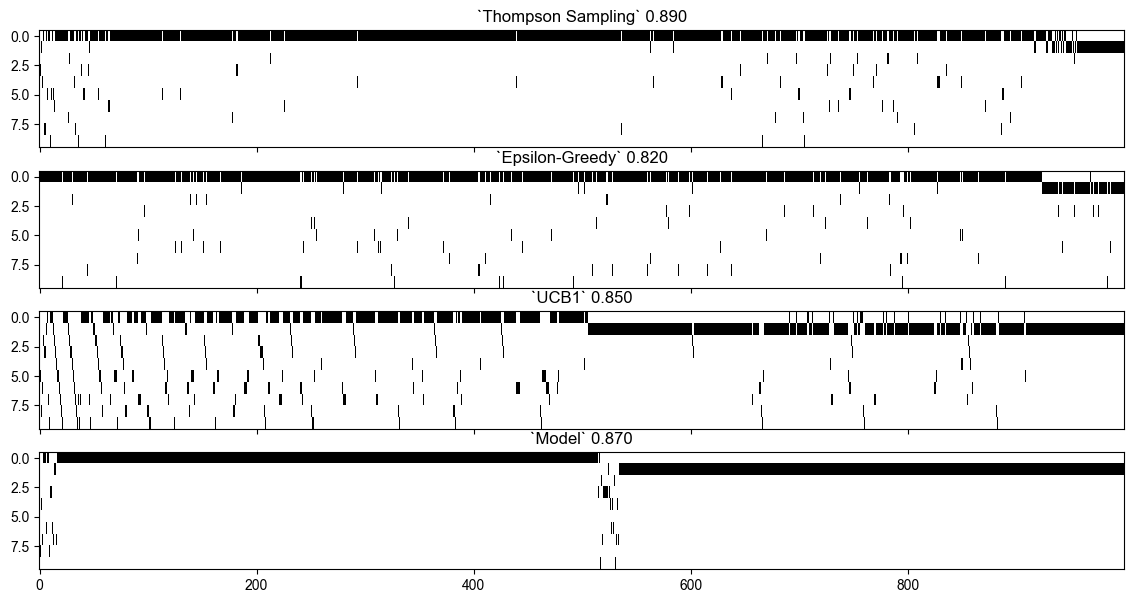

In [78]:
fig, axs = plt.subplots(4, 1, figsize=(14, 7), sharex=True)
for i, ax in enumerate(axs):
    ax.imshow(results['arm_list'][i].reshape(1000, 10).T, cmap="Greys", aspect="auto", interpolation="nearest")
    ax.set_title(f"{results['names'][i]} {results['scores'][i]:.3f}")

plt.show()

In [146]:
def calc_entropy(z):
    p = (z / z.sum())
    p = p[np.where(p != 0)[0]]
    return -(p * np.log(p)).sum()

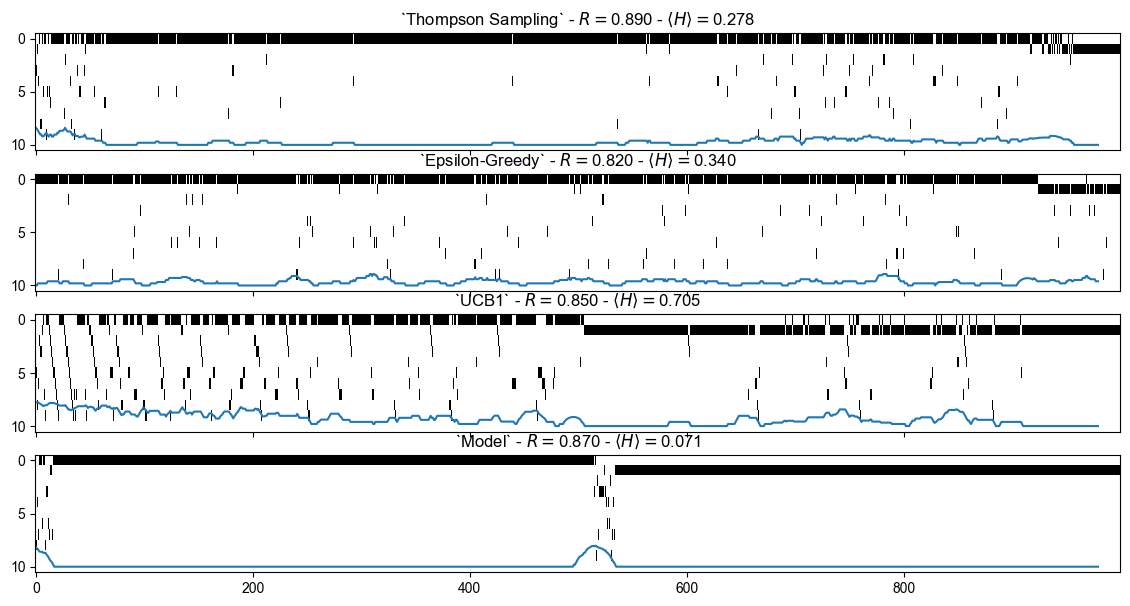

In [165]:
size = 20
fig, axs = plt.subplots(4, 1, figsize=(14, 7), sharex=True)
for i, ax in enumerate(axs):
    ax.imshow(results['arm_list'][i].reshape(1000, 10).T, cmap="Greys", aspect="auto", interpolation="nearest")

    arms = results['arm_list'][i].reshape(1000, 10)
    entropy = np.zeros(1000-size)
    for l in range(0, 1000-size):
        entropy[l] = calc_entropy(arms[l: l+size].sum(axis=0))
    ax.plot(range(1000-size), 10-entropy)
    ax.set_title(f"{results['names'][i]} - $R=${results['scores'][i]:.3f} - $\\langle H \\rangle=${entropy.mean():.3f}")

plt.show()

### run over many envs

In [7]:
settings1 = Settings()
settings1.rounds = 2000
settings1.trials = 2
settings1.reps = 15
settings1.verbose = True
settings1.K = 5
    
logger(f"reps:   {settings1.reps}")
logger(f"trials: {settings1.trials}")
logger(f"rounds: {settings1.rounds}")

all_results = {}

for env_name in ("v0", "driftv0", "driftv1", "sinv0"):
    
    settings1.env = env_name
    logger(f"env:    {settings1.env}")
    
    
    # parameters
    K = settings1.K
    nb_rounds = settings1.rounds
    nb_trials = settings1.trials
    nb_reps = settings1.reps
    verbose = settings1.verbose
    env_type = settings1.env
    
    # define proababilities set
    probabilities_set = []
    for i in range(nb_trials):
        p = np.around(np.random.uniform(0.05, 0.3, K), 2)
        p[i%K] = 0.9
        # p[np.random.randint(0, K)] = 0.9
        probabilities_set += [p.tolist()]
    
    probabilities_set = np.array(probabilities_set)
    
    # define the environment
    if env_type == "driftv0":
        env = envs.KABdriftv0(K=K,
                              probabilities_set=probabilities_set,
                              verbose=verbose,
                              tau=5)
    elif env_type == "driftv1":
        env = envs.KABdriftv1(K=K,
                              verbose=verbose,
                              tau=100,
                              normalize=True,
                              fixed_p=0.9)
    elif env_type == "sinv0":
        frequencies = np.linspace(0, 0.4, K)
        env = envs.KABsinv0(K=K,
                            frequencies=frequencies,
                            normalize=True,
                            verbose=verbose)
    else:
        env = envs.KABv0(K=K,
                         probabilities_set=probabilities_set,
                         verbose=verbose)
    
    if verbose:
        logger.info(f"%env: {env}")
    
    # define models
    if settings1.load:
        # params = utils.load_model(idx=args.idx,
        #                           verbose=verbose)
    
        idx = settings1.idx if settings1.idx >= 0 else None
        params = utils.load_model(idx=idx)
        # params["K"] = K
        params["K"] = K
    
    else:
        params = {
            "K": K,
            "dur_pre": 2000,
            "dur_post": 2000,
            "lr": 0.1,
            "gain": 1.,
            "threshold": 0.5,
            "alpha": 0.,
            "beta": 1.,
            "mu": 0.,
            "sigma": 1.,
            "r": 1.,
            "alpha_lr": 0.1,
            "beta_lr": 0.1,
            "mu_lr": 0.1,
            "sigma_lr": 0.1,
            "r_lr": 0.1,
            "w_max": 5.,
            "value_function": "gaussian",
            "lr_function": "gaussian",
        }
    
    model_list = [
        mm.ThompsonSampling(K=K),
        mm.EpsilonGreedy(K=K, epsilon=0.1),
        mm.UCB1(K=K),
        mm.Model(**params)
    ]
    
    # run
    results = envs.trial_multiple_models(
                         models=model_list,
                         environment=env,
                         nb_trials=nb_trials,
                         nb_rounds=nb_rounds,
                         nb_reps=nb_reps,
                         verbose=settings1.verbose)
    
    all_results[env_name] = results

logger()
logger("#done")

2024-11-26 19:06:52 | reps:   15
2024-11-26 19:06:52 | trials: 2
2024-11-26 19:06:52 | rounds: 2000
2024-11-26 19:06:52 | env:    v0
2024-11-26 19:06:52 | %env: KABv0
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [22:50<00:00, 91.38s/it]
2024-11-26 19:29:42 | env:    driftv0
2024-11-26 19:29:42 | %env: KABdriftv0
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [22:46<00:00, 91.12s/it]
2024-11-26 19:52:29 | env:    driftv1
2024-11-26 19:52:29 | %env: KABdriftv1
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [22:46<00:00, 91.07s/it]
2024-11-26 20:15:15 | env:    sinv0
2024-11-26 20:15:15 | %env: KABsinv0
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [22

In [9]:
all_results['v0'].keys()

dict_keys(['reward_list', 'chance_list', 'upper_bound_list', 'best_arm_list', 'arm_list', 'scores', 'score_list', 'mean_scores', 'entropy_list', 'names'])

In [28]:
""" print score for all """

for (k, v) in all_results.items():

    print(f"[{k}]")
    print(f"\tmax:    {np.mean(v['upper_bound_list']):.3f}")
    print(f"\tchance: {np.mean(v['chance_list']):.3f}")

    for i, name in enumerate(v['names']):
        print(f"\t{name}:\t{v['scores'][i]:.3f} +/- {np.var(v['score_list'][i]):.5f}")

    print()

[v0]
	max:    0.900
	chance: 0.345
	`Thompson Sampling`:	0.901 +/- 0.00052
	`Epsilon-Greedy`:	0.537 +/- 0.09204
	`UCB1`:	0.895 +/- 0.00046
	`Model`:	0.904 +/- 0.00018

[driftv0]
	max:    0.870
	chance: 0.389
	`Thompson Sampling`:	0.759 +/- 0.01718
	`Epsilon-Greedy`:	0.688 +/- 0.01897
	`UCB1`:	0.773 +/- 0.01124
	`Model`:	0.771 +/- 0.00917

[driftv1]
	max:    0.629
	chance: 0.200
	`Thompson Sampling`:	0.553 +/- 0.04150
	`Epsilon-Greedy`:	0.334 +/- 0.06692
	`UCB1`:	0.585 +/- 0.03186
	`Model`:	0.633 +/- 0.01240

[sinv0]
	max:    0.200
	chance: 0.200
	`Thompson Sampling`:	0.189 +/- 0.00054
	`Epsilon-Greedy`:	0.203 +/- 0.00069
	`UCB1`:	0.205 +/- 0.00056
	`Model`:	0.208 +/- 0.00082



-------------------------
## **Simple**

In [315]:
""" settings """
settings1 = Settings()
settings1.rounds = 200
settings1.trials = 3
settings1.reps = 2
settings1.verbose = True
settings1.env = "simple"

In [11]:
""" run """
record = {}

Ks = [5, 10, 15]
for i, k in tqdm(zip(range(len(Ks)), Ks)):
    settings1.K = k
    results = main.main_multiple(args=settings1)
    record[str(i)] = results

print("done")

0it [00:00, ?it/s]2024-08-13 11:09:20 | %env: KArmedBandit(K=5, nb_sets=3)
2024-08-13 11:09:20 | Model info: {'date': '18/06/2024 at 23:11', 'model': 'Model', 'game': 'Env(10:700:1, K=10, env_type=smooth2)', 'evolved': ['tau_u', 'tau_v', 'gain', 'threshold', 'alpha', 'beta', 'mu', 'sigma', 'r', 'alpha_lr', 'beta_lr', 'mu_lr', 'sigma_lr', 'r_lr', 'w_max', 'lr', 'dur_pre', 'dur_post', 'lr_function'], 'data': 'k-armed bandit', 'other': 'all (2 Ks and 3 variants)', 'performance': {'gen': '73', 'fitness': '[0.65743]'}}
2024-08-13 11:09:20 | %names: ['`Thompson Sampling`', '`Epsilon-Greedy`', '`UCB1`', '`Model`']
2024-08-13 11:09:20 | %reps=2
2024-08-13 11:09:20 | %trials=3
2024-08-13 11:09:20 | %rounds=200
2024-08-13 11:09:20 | Model: `Thompson Sampling`
2024-08-13 11:09:20 | Model: `Epsilon-Greedy`
2024-08-13 11:09:20 | Model: `UCB1`
2024-08-13 11:09:20 | Model: `Model`
2024-08-13 11:09:20 | K-armed bandit: KArmedBandit(K=5, nb_sets=3)

  0%|                                                

done


In [12]:
record.keys()

dict_keys(['0', '1', '2'])

In [ ]:

record['0']['upper_bound_list'][0]

In [ ]:
record['0']['reward_list'][0].mean(axis=0).shape

ValueError: zero-size array to reduction operation minimum which has no identity

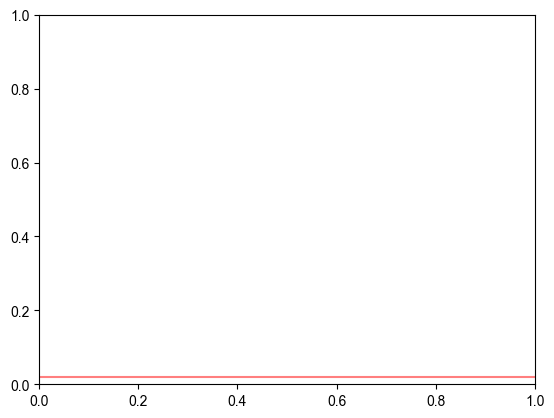

In [13]:

def plot(idx, color, m=2, theta=0.0125):

    # array of mean reward for each round over reps for a given trial
    z = record[f'{m}']['reward_list'][idx][:, 0].mean(axis=0)
    name = record['0']['names'][idx]

    # steady-state reward : last ~50
    mu_ref = z[-50:].mean()

    # residuals
    res = (z - mu_ref)**2

    # 1d convolution over y
    kc = 30
    y = convolve1d(res, np.ones(kc), mode="constant")/kc

    # point of stability
    cy_idx = np.where(y<theta)[0].min()
    plt.axvline(cy_idx, color=color, alpha=0.5, linestyle='-.',
                label=f"{cy_idx}")

    plt.plot(convolve1d(z, np.ones(kc), mode="constant")/kc,
             color=color,
             alpha=0.5, label=f"{name} residuals")
    plt.plot(y, alpha=0.5, linestyle='--', color=color,
             label=f"{name} rewards")

theta = 0.02
plt.axhline(y=theta, color='red', alpha=0.5)
plot(idx=1, color='grey', theta=theta)
plot(idx=2, color='blue', theta=theta)
plot(idx=3, color='green', theta=theta)
plt.legend(loc="lower right")
plt.show()

[0.14058667 0.14179    0.14499333 0.14819667 0.1514     0.15460333
 0.15780667 0.15901    0.16021333 0.16341667 0.16662    0.16982333
 0.17302667 0.17623    0.1981     0.1961     0.17743333 0.15676667
 0.15476667 0.15476667 0.15476667 0.17543333 0.17543333 0.15676667
 0.1381     0.1381     0.11943333 0.1381     0.15676667 0.17543333
 0.1941     0.21476667 0.21276667 0.21276667 0.23143333 0.23143333
 0.23143333 0.23343333 0.23543333 0.23543333 0.2541     0.2541
 0.2521     0.2521     0.2521     0.2541     0.2541     0.2561
 0.27676667 0.27676667 0.27676667 0.2581     0.27876667 0.27876667
 0.27876667 0.27676667 0.27676667 0.2581     0.23943333 0.22076667
 0.2021     0.18343333 0.18543333 0.18543333 0.16476667 0.16276667
 0.16076667 0.16076667 0.16076667 0.16076667 0.1421     0.16076667
 0.16276667 0.18143333 0.16276667 0.16276667 0.16276667 0.18143333
 0.16276667 0.16276667 0.16276667 0.16276667 0.1441     0.1441
 0.1441     0.1441     0.1441     0.1441     0.1441     0.1421
 0.16076667

NameError: name 'rounds' is not defined

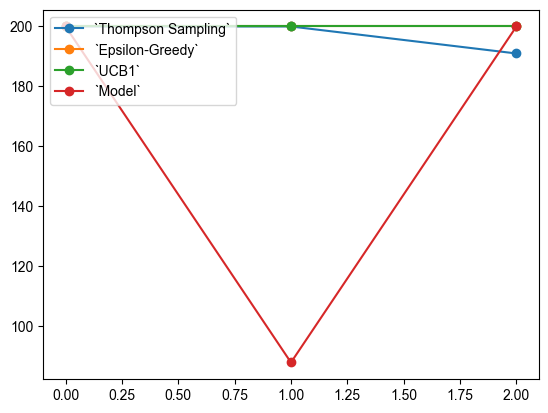

In [14]:
""" make the plot over different `K` """

def calc_stability_points(record, idx):

    points = []

    for _, k_record in record.items():

        # array of mean reward for each round over reps for a given trial
        z = k_record['reward_list'][idx][:, 0].mean(axis=0)
        name = k_record['names'][idx]

        # steady-state reward : last ~50
        mu_ref = z[-50:].mean()

        # residuals
        res = (z - mu_ref)**2

        # 1d convolution over y
        kc = 30
        y = convolve1d(res, np.ones(kc), mode="constant")/kc

        # point of stability
        print(y)
        p = np.where(y<0.02)[0]
        if len(p) < 2:
            points += [len(z)]
        else:
            points += [p.min()]

    return points, name


""" make plot """

colors = plt.cm.tab10(range(4))
for i in range(4):

    points, name = calc_stability_points(record, idx=i)

    print(f"{name}: {points}")

    plt.plot(points, '-o', color=colors[i], label=name)

# plt.yticks(np.arange(0, 1, 0.01), ())
plt.legend(loc="upper left")
plt.xticks(range(len(rounds)), rounds)
plt.grid()
plt.show()

-------------------------
## **Smooth**

In [ ]:
""" settings """
settings2 = Settings()
settings2.rounds = 1
settings2.trials = 300
settings2.reps = 2
settings2.K = 10
settings2.env = "smooth2"

In [ ]:
""" run """
record2 = {}

rounds = [1, 2]
for i, k in tqdm(zip(range(len(rounds)), rounds)):
    print(f"{i=} {k=}")
    settings2.rounds = k
    results2 = main.main_multiple(args=settings2)
    record2[str(i)] = results2

print("done")

In [ ]:
record2['0']['reward_list'].shape

In [ ]:
record2['0']['upper_bound_list'][:, 0].shape

In [ ]:
record2['0']['reward_list'][-1].mean(axis=0).mean(axis=1).shape

In [ ]:
z = record2['0']['reward_list'][-1].mean(axis=0).mean(axis=1)
mu_ref = z[-50:].mean()
res = (z - mu_ref)**2
y = convolve1d(res, np.ones(50), mode="constant")/50

kc = 100
yc = convolve1d(z, np.ones(kc), mode="constant")/kc
# plt.plot(y)
plt.plot(yc)

plt.show()

In [ ]:
def relu(x):
    return x*(x>0).astype(int)

In [ ]:

def calc_reg(record, ki, mi):
    z = record[f'{ki}']['reward_list'][mi].mean(axis=0).mean(axis=1)
    upper = record['0']['upper_bound_list'][0]
    res = relu(upper - z)
    return res.sum()


colors = plt.cm.tab10(range(4))
for i in range(4):
    res_m = []
    for ki in range(4):
        res_m += [calc_reg(record2, ki, i)]

    name = record2['0']['names'][i]
    plt.plot(res_m, '-o', color=colors[i], 
             label=name)

plt.legend(loc="upper left")
plt.xticks(range(4), rounds)
# plt.ylim(0, 200)
plt.show()

In [ ]:
z = record2[f'3']['reward_list'][1].mean(axis=0).mean(axis=1)
plt.plot(z)
plt.show()

In [ ]:
upper = record['0']['upper_bound_list'][0]
upper.shape

---
## **Other**

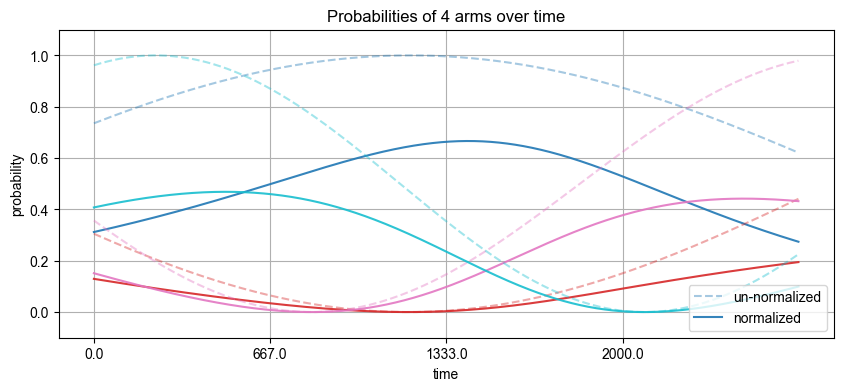

In [46]:
N = 4
#F = list(range(N))
H = np.zeros(N)

F = np.random.uniform(0, 0.4, N)
H = np.random.uniform(0, N, N)


x = np.arange(0, 2, 0.001)
y = np.zeros((len(F), len(x)))


fig, ax = plt.subplots(figsize=(10, 4))

for i in range(N):
    y[i] = 0.5*np.sin(2*np.pi*x*F[i] + H[i]) + 0.5

z = y/y.sum(axis=0)

colors = plt.cm.tab10(np.linspace(0, 1, N))

for i, (zi, yi) in enumerate(zip(z, y)):
    if i > 0:
        ax.plot(x, yi, linestyle='--', color=colors[i], alpha=0.4)
        ax.plot(x, zi, color=colors[i], alpha=0.9)
        continue
    ax.plot(x, yi, linestyle='--', color=colors[i], alpha=0.4,
           label="un-normalized")
    ax.plot(x, zi, color=colors[i], alpha=0.9, label="normalized")

ax.set_ylim((-0.1, 1.1))
xl = np.arange(0, max(x), 0.5)
ax.set_xticks(xl)
ax.set_xticklabels(np.around(np.linspace(0, len(x), len(xl)), 0))
ax.set_xlabel("time")
ax.set_ylabel("probability")
ax.set_title(f"Probabilities of {N} arms over time")
ax.grid()
ax.legend(loc="lower right")
plt.show()

In [78]:
xl

array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5])

In [287]:
fig.savefig("paper/figures/kab_sinv0.png", dpi=500)
print("done")

done


In [311]:
a = np.arange(0, 10, 1)
a

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [312]:
np.mode(a)

AttributeError: module 'numpy' has no attribute 'mode'

In [2]:
env = envs.KABsinv0(K=4, frequencies=list(range(4)), normalize=True)
print(env)

KABsinv0


In [40]:
args.K

5